# Phe vs Roche Model Comparison

In this notebook we use the `epimodels` module to investigate how non-pharmaceutical interventions impact the outcome of the epidemic. We use two models: the _PHE model_ by niversity of Cambridge and the _Roche model_ by F. Hoffmann-La Roche Ltd, and run a forward simulation simulation both with and without NPIs, after they have been fitted to serology data.

The analyses are run for:
 - Dates: **15 Feb 2020** - **15 May 2020**;
 - PHE regions of interest: **London**.

We use realistic serology and mortality data extracted from the REACT survey and GOV.UK data.

*The PHE model is built by Public Health England in collaboration with University of Cambridge. The Roche model is built by F. Hoffmann-La Roche Ltd.*

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(27)

## Model Setup
### Define setup matrices for the PHE and Roche Model + NPIs

In [2]:
# Populate the model
total_days =  132
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))

### Variable
matrices_region_var = []

# Initial state of the system
for w in weeks:
    weeks_matrices_region_var = []
    for r in regions:
        path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
        region_data_matrix_var = pd.read_csv(path, header=None, dtype=np.float64)
        regional_var = em.RegionMatrix(r, age_groups, region_data_matrix_var)
        weeks_matrices_region_var.append(regional_var)

    matrices_region_var.append(weeks_matrices_region_var)

contacts_var = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact_var = [contacts_var]

# Matrices contact
time_changes_contact_var = [1]
time_changes_region_var = np.arange(1, total_days+1, 7).tolist()

### Fixed
matrices_region_fix = []

# Initial state of the system
weeks_matrices_region_fix = []
for r in regions:
    path = os.path.join('../../data/final_contact_matrices/BASE.csv')
    region_data_matrix_fix = pd.read_csv(path, header=None, dtype=np.float64)
    regional_fix = em.RegionMatrix(r, age_groups, region_data_matrix_fix)
    weeks_matrices_region_fix.append(regional_fix)

matrices_region_fix.append(weeks_matrices_region_fix)

contacts_fix = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact_fix = [contacts_fix]

# Matrices contact
time_changes_contact_fix = [1]
time_changes_region_fix = [1]

### With NPIs data
max_levels_npi = [3, 3, 2, 4, 2, 3, 2, 4, 2]
targeted_npi = [True, True, True, True, True, True, True, False, True]
path = os.path.join('../../data/npi_data/')
general_npi_yes = np.loadtxt(os.path.join(path, 'uk_flags.csv'), dtype=bool, delimiter=',').tolist()
time_changes_flag_yes = np.loadtxt(os.path.join(path, 'times_flags.csv'), dtype=int, delimiter=',').tolist()

reg_levels_npi_yes = [np.loadtxt(os.path.join(path, 'uk_npis.csv'), dtype=int, delimiter=',').tolist()]
time_changes_npi_yes = np.loadtxt(os.path.join(path, 'times_npis.csv'), dtype=int, delimiter=',').tolist()

### No NPIs
general_npi_no = [[False, False, False, False, False, False, False, False, False]]
time_changes_flag_no = [1]

reg_levels_npi_no = [[[0, 0, 0, 0, 0, 0, 0, 0, 0]]]
time_changes_npi_no = [1]


### Set the parameters and initial conditions of the model and bundle everything together

### PHE with variable contacts

In [3]:
# Instantiate model
phe_model_var = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
phe_model_var.set_regions(regions)
phe_model_var.set_age_groups(age_groups)
phe_model_var.read_contact_data(matrices_contact_var, time_changes_contact_var)
phe_model_var.read_regional_data(matrices_region_var, time_changes_region_var)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[1]

# Initial number of infectives
ICs_multiplier = 50
infectives1 = (ICs_multiplier * np.ones((len(regions), len(age_groups)))).tolist()

infectives2 = np.zeros((len(regions), len(age_groups))).tolist()


# List of times at which we wish to evaluate the states of the compartments of the phe_model_var
times = np.arange(1, total_days+1, 1).tolist()

In [4]:
### Variable Model
# Set regional and time dependent parameters
phe_model_var_regional_parameters = em.PheRegParameters(
    model=phe_model_var,
    initial_r=[2.35],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
phe_model_var_ICs = em.PheICs(
    model=phe_model_var,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
phe_model_var_disease_parameters = em.PheDiseaseParameters(
    model=phe_model_var,
    dL=4,
    dI=4
)

# Set other simulation parameters
phe_model_var_simulation_parameters = em.PheSimParameters(
    model=phe_model_var,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
phe_model_var_parameters = em.PheParametersController(
    model=phe_model_var,
    regional_parameters=phe_model_var_regional_parameters,
    ICs=phe_model_var_ICs,
    disease_parameters=phe_model_var_disease_parameters,
    simulation_parameters=phe_model_var_simulation_parameters
)

### PHE with fixed contacts

In [5]:
# Instantiate phe_model_var
phe_model_fix = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
phe_model_fix.set_regions(regions)
phe_model_fix.set_age_groups(age_groups)
phe_model_fix.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
phe_model_fix.read_regional_data(matrices_region_fix, time_changes_region_fix)


In [6]:
### Fixed Model
# Set regional and time dependent parameters
phe_model_fix_regional_parameters = em.PheRegParameters(
    model=phe_model_fix,
    initial_r=[2.35],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
phe_model_fix_ICs = em.PheICs(
    model=phe_model_fix,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
phe_model_fix_disease_parameters = em.PheDiseaseParameters(
    model=phe_model_fix,
    dL=4,
    dI=4
)

# Set other simulation parameters
phe_model_fix_simulation_parameters = em.PheSimParameters(
    model=phe_model_fix,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
phe_model_fix_parameters = em.PheParametersController(
    model=phe_model_fix,
    regional_parameters=phe_model_fix_regional_parameters,
    ICs=phe_model_fix_ICs,
    disease_parameters=phe_model_fix_disease_parameters,
    simulation_parameters=phe_model_fix_simulation_parameters
)

### Roche with NPIs

In [7]:
# # Instantiate model
# roche_model_var = em.RocheSEIRModel()

# # Set the region names, contact and regional data of the model
# roche_model_var.set_regions(regions)
# roche_model_var.set_age_groups(age_groups)
# roche_model_var.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
# roche_model_var.read_regional_data(matrices_region_fix, time_changes_region_fix)
# roche_model_var.read_npis_data(max_levels_npi, targeted_npi, general_npi_yes, reg_levels_npi_yes, time_changes_npi_yes, time_changes_flag_yes)

# # Initial number of susceptibles
# path = os.path.join('../../data/england_population/England_population.csv')
# total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
# susceptibles = []
# susceptibles.append(total_susceptibles[-1])

# # Initial number of infectives
# ICs_multiplier = [30, 5]
# infectives_pre = (ICs_multiplier[0] * np.ones((len(regions), len(age_groups)))).tolist()
# infectives_pre_ss = (ICs_multiplier[1] * np.ones((len(regions), len(age_groups)))).tolist()

# infectives = (np.array(infectives_pre) + np.array(infectives_pre_ss)).tolist()

# # List of times at which we wish to evaluate the states of the compartments of the model
# times = np.arange(1, total_days+1, 1).tolist()

In [8]:
# # Set ICs parameters
# roche_model_var_ICs = em.RocheICs(
#     model=roche_model_var,
#     susceptibles_IC=susceptibles,
#     exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_pre_IC=infectives_pre,
#     infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_sym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_pre_ss_IC=infectives_pre_ss,
#     infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
# )

# # Set average times in compartments
# roche_model_var_compartment_times = em.RocheCompartmentTimes(
#     model=roche_model_var,
#     k=2.59,
#     kS=4.28,
#     kQ=1,
#     kR=9,
#     kRI=10
# )

# # Set proportion of asymptomatic, super-spreader and dead cases
# roche_model_var_proportion_parameters = em.RocheProportions(
#     model=roche_model_var,
#     Pa = 0.716,
#     Pss = 0.106,
#     Pd = 0.05
# )

# # Set transmission parameters
# roche_model_var_transmission_parameters = em.RocheTransmission(
#     model=roche_model_var,
#     beta_min=0.228,
#     beta_max=2.63,
#     bss=3.11,
#     gamma=1,
#     s50=34.9
# )

# # Set other simulation parameters
# roche_model_var_simulation_parameters = em.RocheSimParameters(
#     model=roche_model_var,
#     region_index=1,
#     method='RK45',
#     times=times
# )

# # Set all parameters in the controller
# roche_model_var_parameters = em.RocheParametersController(
#     model=roche_model_var,
#     ICs=roche_model_var_ICs,
#     compartment_times=roche_model_var_compartment_times,
#     proportion_parameters=roche_model_var_proportion_parameters,
#     transmission_parameters=roche_model_var_transmission_parameters,
#     simulation_parameters=roche_model_var_simulation_parameters
# )

### Roche without NPIs

In [9]:
# # Instantiate model
# roche_model_fix = em.RocheSEIRModel()

# # Set the region names, contact and regional data of the model
# roche_model_fix.set_regions(regions)
# roche_model_fix.set_age_groups(age_groups)
# roche_model_fix.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
# roche_model_fix.read_regional_data(matrices_region_fix, time_changes_region_fix)
# roche_model_fix.read_npis_data(max_levels_npi, targeted_npi, general_npi_no, reg_levels_npi_no, time_changes_npi_no, time_changes_flag_no)

In [10]:
# # Set ICs parameters
# roche_model_fix_ICs = em.RocheICs(
#     model=roche_model_fix,
#     susceptibles_IC=susceptibles,
#     exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_pre_IC=infectives_pre,
#     infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_sym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_pre_ss_IC=infectives_pre_ss,
#     infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
#     dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
# )

# # Set average times in compartments
# roche_model_fix_compartment_times = em.RocheCompartmentTimes(
#     model=roche_model_fix,
#     k=2.59,
#     kS=4.28,
#     kQ=1,
#     kR=9,
#     kRI=10
# )

# # Set proportion of asymptomatic, super-spreader and dead cases
# roche_model_fix_proportion_parameters = em.RocheProportions(
#     model=roche_model_fix,
#     Pa = 0.716,
#     Pss = 0.106,
#     Pd = 0.05
# )

# # Set transmission parameters
# roche_model_fix_transmission_parameters = em.RocheTransmission(
#     model=roche_model_fix,
#     beta_min=0.228,
#     beta_max=2.63,
#     bss=3.11,
#     gamma=1,
#     s50=34.9
# )

# # Set other simulation parameters
# roche_model_fix_simulation_parameters = em.RocheSimParameters(
#     model=roche_model_fix,
#     region_index=1,
#     method='RK45',
#     times=times
# )

# # Set all parameters in the controller
# roche_model_fix_parameters = em.RocheParametersController(
#     model=roche_model_fix,
#     ICs=roche_model_fix_ICs,
#     compartment_times=roche_model_fix_compartment_times,
#     proportion_parameters=roche_model_fix_proportion_parameters,
#     transmission_parameters=roche_model_fix_transmission_parameters,
#     simulation_parameters=roche_model_fix_simulation_parameters
# )

## Death and Serology data
### Read Death and Serology data

In [11]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

In [12]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [13]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

## Model Fitting
### PHE (with variable contacts)

In [14]:
# Initialise inference for the model
phe_inference_var = em.inference.PheSEIRInfer(phe_model_var)

# Add model, death and tests data to the inference structure
phe_inference_var.read_model_data(susceptibles, infectives1)
phe_inference_var.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
phe_inference_var.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run inference structure
phe_var_samples = phe_inference_var.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time m:s
0     12     -7351.116 -7351.116   0:01.0
1     24     -7110.515 -7110.515   0:01.9
2     36     -6767.776 -6767.776   0:02.8
3     48     -6328.045 -6328.045   0:03.7


/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:343: RuntimeWarning: invalid value encountered in log
  np.log(x[r*LEN+d+1]),
/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:344: RuntimeWarning: invalid value encountered in log
  loc=np.log(x[r*LEN+d]),


20    252    -2981.649 -3112.28    0:21.5
40    492    -2859.826 -2859.826   0:42.7
60    732    -2822.718 -2828.536   1:03.7
80    972    -2796.871 -2796.871   1:24.1
100   1212   -2784.762 -2784.762   1:44.0
120   1452   -2777.248 -2778.816   2:03.4
140   1692   -2776.247 -2776.247   2:22.2
160   1932   -2775.954 -2775.954   2:41.0
180   2172   -2775.388 -2775.388   2:59.8
200   2412   -2775.048 -2775.065   3:18.6
220   2652   -2774.945 -2774.955   3:37.3
240   2892   -2774.854 -2774.854   3:56.1
260   3132   -2774.797 -2774.797   4:14.7
271   3252   -2774.763 -2774.772   4:23.9
Halting: No significant change for 100 iterations.
[3.27948584 0.51935873 0.33850297 0.34523343 0.41786423 0.48372222
 0.49325802 0.47609956 0.46852141 0.46487261 0.49825978 0.53833774
 0.58893482 0.61038777 0.15704069] -2774.763041452868
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in parallel with 3 worker processess.
Iter. Eval.  Acc

### Quality check of the inference procedure

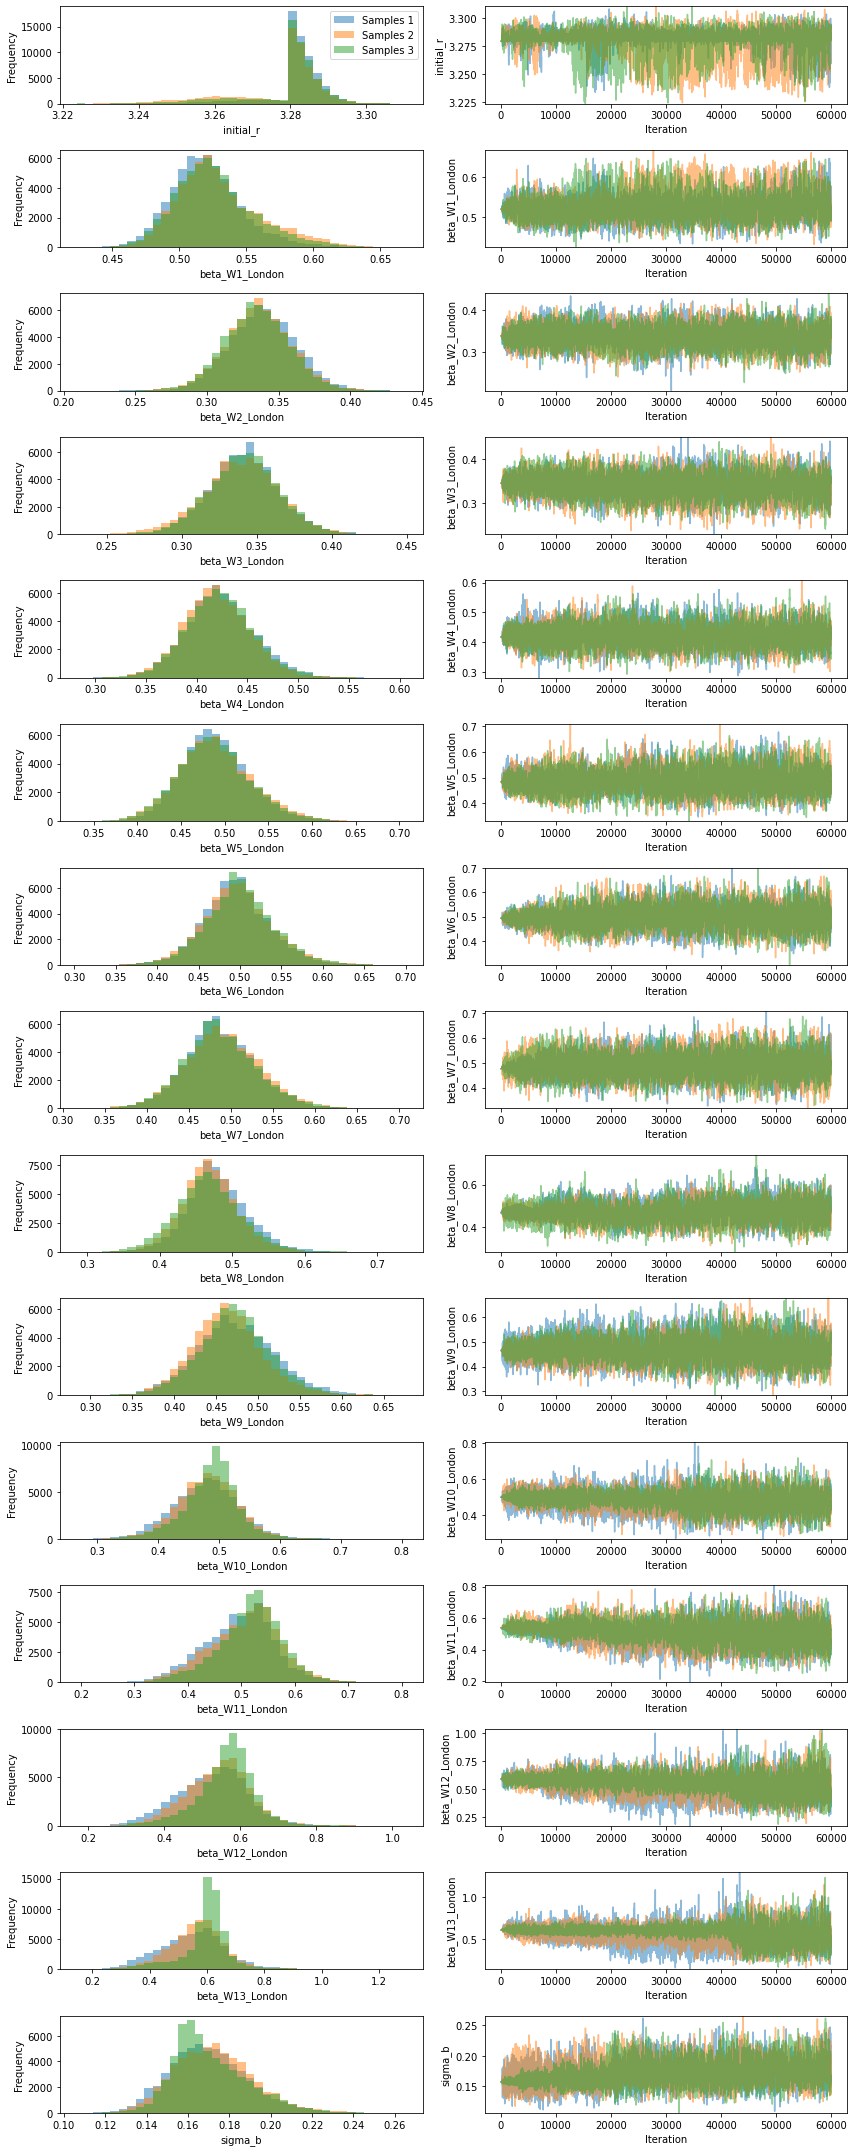

In [15]:
import pints.plot
 
# Plot histograms of the parameters inferred for London
param_names = ['initial_r']
param_names.extend(['beta_W{}_London'.format(i+1) for i in range(len(np.arange(44, len(times), 7)))])
param_names.extend(['sigma_b'])

pints.plot.trace(phe_var_samples, parameter_names=param_names)
plt.show()

In [16]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
phe_var_samples = phe_var_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(phe_var_samples))

[1.05044861 1.03176457 1.00998221 1.00859269 1.00606331 1.00453755
 1.00293481 1.00577333 1.00708576 1.00274582 1.00161647 1.01183739
 1.02380774 1.03084602 1.00774993]


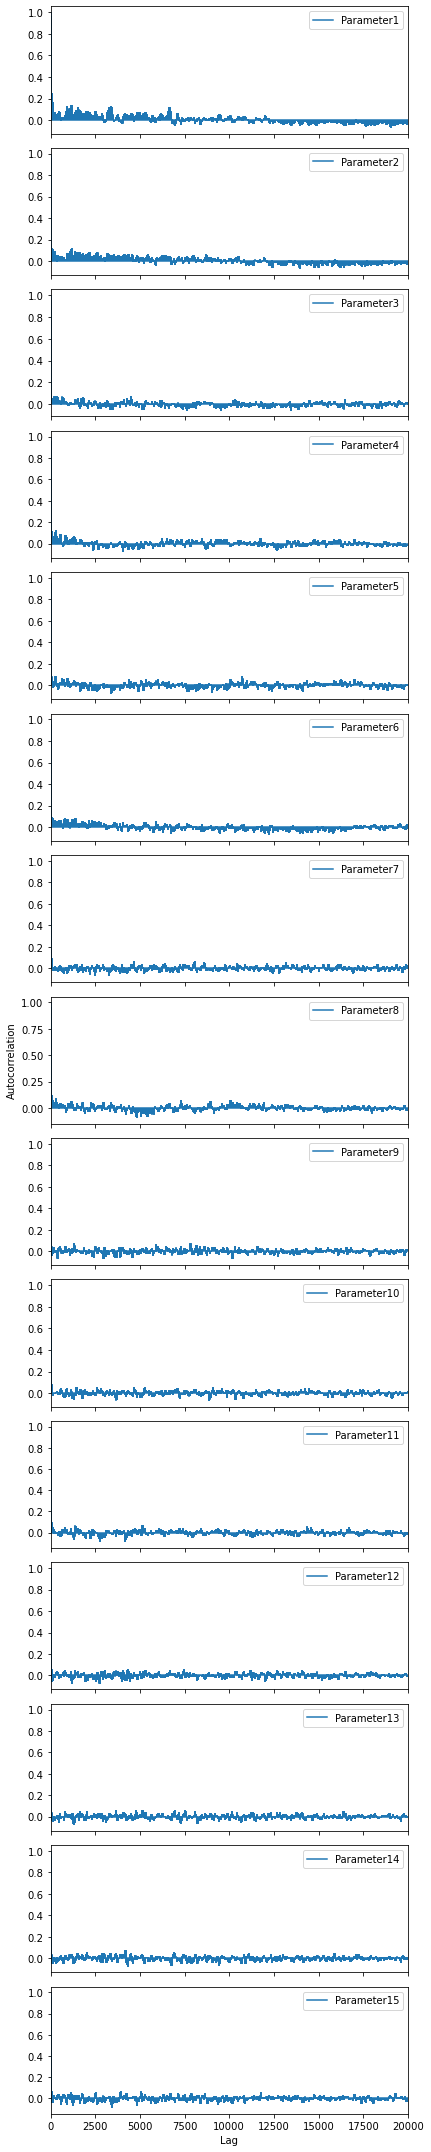

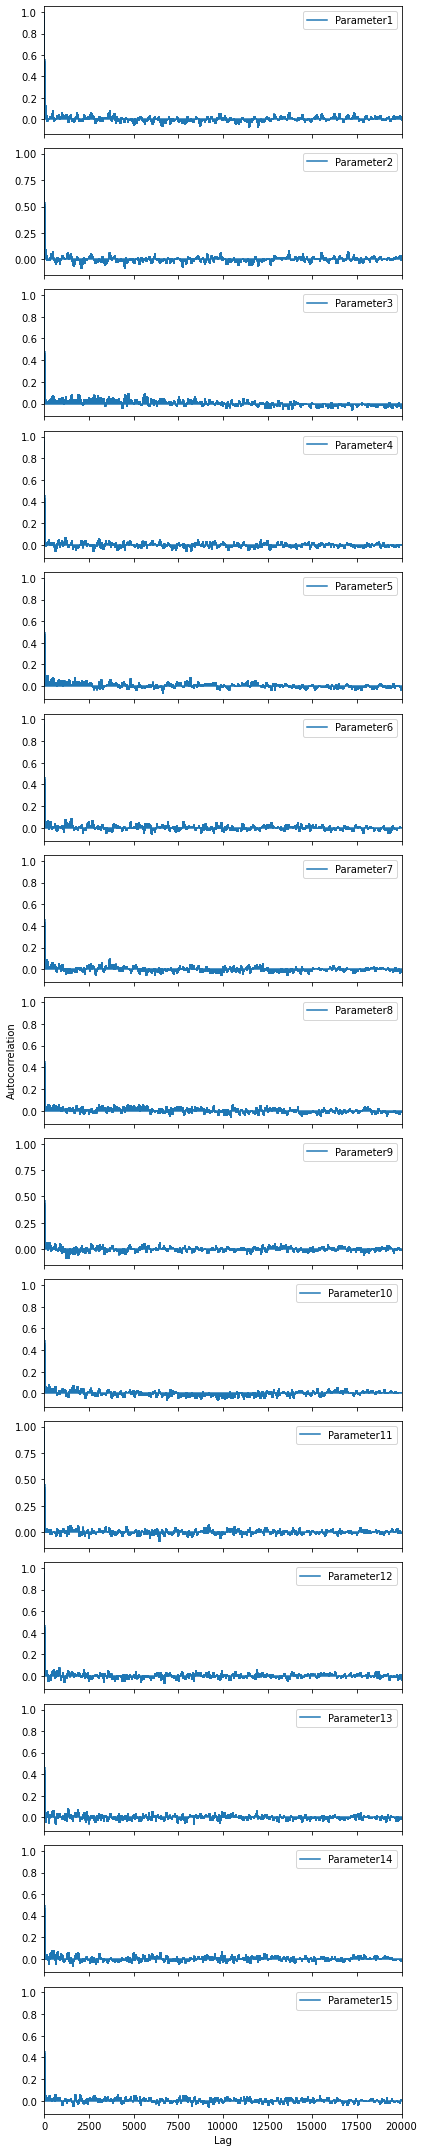

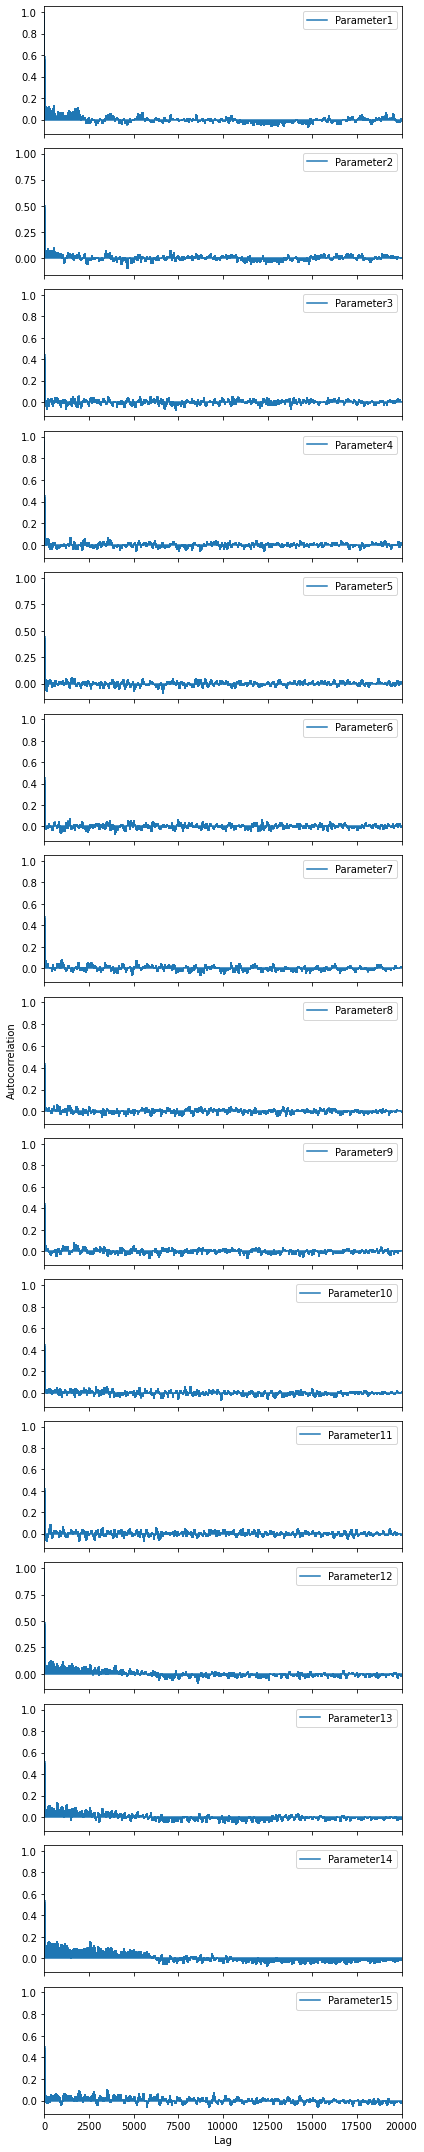

In [17]:
# Plot the autocorrelation for the three chains of parameters for South West
for phe_var_sample in phe_var_samples:
    pints.plot.autocorrelation(phe_var_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

### PHE with variable contacts

In [18]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = phe_var_samples.shape

phe_var_extended_samples = np.concatenate((phe_var_samples[0], phe_var_samples[1], phe_var_samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

phe_var_predicted_new_infec = []
phe_var_predicted_deaths = []
phe_var_predicted_reprod_num = []

phe_fix_predicted_new_infec = []
phe_fix_predicted_deaths = []
phe_fix_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    phe_var_reg_predicted_new_infec = []
    phe_var_reg_predicted_deaths = []
    phe_var_reg_predicted_reprod_num = []

    phe_model_var_parameters.regional_parameters.region_index = r+1
    phe_model_fix_parameters.regional_parameters.region_index = r+1

    for params in phe_var_extended_samples[::thinning, :]:
        phe_model_var_parameters.regional_parameters.initial_r = [params[0]] * len(phe_model_var.regions)
        LEN = len(np.arange(44, len(times), 7))

        betas = np.array(phe_model_var_parameters.regional_parameters.betas)
        for r in range(len(regions)):
            for d, day in enumerate(np.arange(44, len(times), 7)):
                betas[r, day:(day+7)] = params[r*LEN+d+1]

        phe_model_var_parameters.regional_parameters.betas = betas.tolist()

        phe_var_r_fix = np.empty(len(times))
        phe_var_model_reg_deaths_data = np.empty(len(times))

        phe_var_m_fix = em.MultiTimesInfectivity(
            matrices_contact_var, time_changes_contact_var, regions, matrices_region_var, time_changes_region_var,
            phe_model_var_parameters.regional_parameters.initial_r, phe_model_var_parameters.disease_parameters.dI,
            phe_model_var_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        phe_var_model_output = phe_model_var.simulate(phe_model_var_parameters)
        
        phe_var_age_model_reg_new_infections = phe_model_var.new_infections(phe_var_model_output)
        phe_var_model_reg_new_infections = phe_var_age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            phe_var_r_fix[t] = phe_var_m_fix.compute_reproduction_number(
                r+1, time, phe_var_model_output[t, :len(age_groups)],
                temp_variation=phe_model_var_parameters.regional_parameters.betas[r][t])
            phe_var_model_reg_deaths_data[t] = np.sum(phe_model_var.mean_deaths(
                fatality_ratio, time_to_death, t, phe_var_age_model_reg_new_infections))

        phe_var_reg_predicted_new_infec.append(phe_var_model_reg_new_infections)
        phe_var_reg_predicted_deaths.append(phe_var_model_reg_deaths_data)
        phe_var_reg_predicted_reprod_num.append(phe_var_r_fix)

    phe_var_reg_predicted_new_infec = np.array(phe_var_reg_predicted_new_infec)
 
    phe_var_predicted_new_infec.append(phe_var_reg_predicted_new_infec)
    phe_var_predicted_deaths.append(phe_var_reg_predicted_deaths)
    phe_var_predicted_reprod_num.append(phe_var_reg_predicted_reprod_num)

phe_var_predicted_new_infec = np.array(phe_var_predicted_new_infec)
phe_var_predicted_deaths = np.array(phe_var_predicted_deaths)
phe_var_predicted_reprod_num = np.array(phe_var_predicted_reprod_num)


<ipython-input-18-bb125843fee0>:51: ComplexWarning: Casting complex values to real discards the imaginary part
  phe_var_r_fix[t] = phe_var_m_fix.compute_reproduction_number(


### PHE with fixed contacts

In [19]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = phe_var_samples.shape

phe_var_extended_samples = np.concatenate((phe_var_samples[0], phe_var_samples[1], phe_var_samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

phe_fix_predicted_new_infec = []
phe_fix_predicted_deaths = []
phe_fix_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    phe_fix_reg_predicted_new_infec = []
    phe_fix_reg_predicted_deaths = []
    phe_fix_reg_predicted_reprod_num = []

    phe_model_fix_parameters.regional_parameters.region_index = r+1

    for params in phe_var_extended_samples[::thinning, :]:
        phe_model_fix_parameters.regional_parameters.initial_r = [params[0]] * len(phe_model_fix.regions)
        
        phe_fix_r_fix = np.empty(len(times))
        phe_fix_model_reg_deaths_data = np.empty(len(times))

        phe_fix_m_fix = em.MultiTimesInfectivity(
            matrices_contact_fix, time_changes_contact_fix, regions, matrices_region_fix, time_changes_region_fix,
            phe_model_fix_parameters.regional_parameters.initial_r, phe_model_fix_parameters.disease_parameters.dI,
            phe_model_fix_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        phe_fix_model_output = phe_model_fix.simulate(phe_model_fix_parameters)

        phe_fix_age_model_reg_new_infections = phe_model_fix.new_infections(phe_fix_model_output)
        phe_fix_model_reg_new_infections = phe_fix_age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            phe_fix_r_fix[t] = phe_fix_m_fix.compute_reproduction_number(
                r+1, time, phe_fix_model_output[t, :len(age_groups)],
                temp_variation=phe_model_fix_parameters.regional_parameters.betas[r][t])
            phe_fix_model_reg_deaths_data[t] = np.sum(phe_model_fix.mean_deaths(
                fatality_ratio, time_to_death, t, phe_fix_age_model_reg_new_infections))

        phe_fix_reg_predicted_new_infec.append(phe_fix_model_reg_new_infections)
        phe_fix_reg_predicted_deaths.append(phe_fix_model_reg_deaths_data)
        phe_fix_reg_predicted_reprod_num.append(phe_fix_r_fix)

    phe_fix_reg_predicted_new_infec = np.array(phe_fix_reg_predicted_new_infec)

    phe_fix_predicted_new_infec.append(phe_fix_reg_predicted_new_infec)
    phe_fix_predicted_deaths.append(phe_fix_reg_predicted_deaths)
    phe_fix_predicted_reprod_num.append(phe_fix_reg_predicted_reprod_num)

phe_fix_predicted_new_infec = np.array(phe_fix_predicted_new_infec)
phe_fix_predicted_deaths = np.array(phe_fix_predicted_deaths)
phe_fix_predicted_reprod_num = np.array(phe_fix_predicted_reprod_num)

### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### PHE with variable contacts

In [20]:
# Set up traces to plot
phe_var_new_infec_mean = []
phe_var_deaths_mean = []
phe_var_reprod_num_mean = []

phe_var_new_infec_upper = []
phe_var_deaths_upper = []
phe_var_reprod_num_upper = []

phe_var_new_infec_lower = []
phe_var_deaths_lower = []
phe_var_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    phe_var_new_infec_mean.append(np.mean(phe_var_predicted_new_infec[r,:,:], axis=0))
    phe_var_deaths_mean.append(np.mean(phe_var_predicted_deaths[r,:,:], axis=0))
    phe_var_reprod_num_mean.append(np.mean(phe_var_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    phe_var_new_infec_upper.append(np.quantile(phe_var_predicted_new_infec[r,:,:], 0.975, axis=0))
    phe_var_deaths_upper.append(np.quantile(phe_var_predicted_deaths[r,:,:], 0.975, axis=0))
    phe_var_reprod_num_upper.append(np.quantile(phe_var_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    phe_var_new_infec_lower.append(np.quantile(phe_var_predicted_new_infec[r,:,:], 0.025, axis=0))
    phe_var_deaths_lower.append(np.quantile(phe_var_predicted_deaths[r,:,:], 0.025, axis=0))
    phe_var_reprod_num_lower.append(np.quantile(phe_var_predicted_reprod_num[r,:,:], 0.025, axis=0))

### PHE with fixed contacts

In [21]:
# Set up traces to plot
phe_fix_new_infec_mean = []
phe_fix_deaths_mean = []
phe_fix_reprod_num_mean = []

phe_fix_new_infec_upper = []
phe_fix_deaths_upper = []
phe_fix_reprod_num_upper = []

phe_fix_new_infec_lower = []
phe_fix_deaths_lower = []
phe_fix_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    phe_fix_new_infec_mean.append(np.mean(phe_fix_predicted_new_infec[r,:,:], axis=0))
    phe_fix_deaths_mean.append(np.mean(phe_fix_predicted_deaths[r,:,:], axis=0))
    phe_fix_reprod_num_mean.append(np.mean(phe_fix_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    phe_fix_new_infec_upper.append(np.quantile(phe_fix_predicted_new_infec[r,:,:], 0.975, axis=0))
    phe_fix_deaths_upper.append(np.quantile(phe_fix_predicted_deaths[r,:,:], 0.975, axis=0))
    phe_fix_reprod_num_upper.append(np.quantile(phe_fix_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    phe_fix_new_infec_lower.append(np.quantile(phe_fix_predicted_new_infec[r,:,:], 0.025, axis=0))
    phe_fix_deaths_lower.append(np.quantile(phe_fix_predicted_deaths[r,:,:], 0.025, axis=0))
    phe_fix_reprod_num_lower.append(np.quantile(phe_fix_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Roche (with NPIs)

In [22]:
# # Initialise inference for the model
# roche_inference_var = em.inference.RocheSEIRInfer(roche_model_var)

# # Add model, death, tests and NPIs data to the inference structure
# roche_inference_var.read_model_data(susceptibles, infectives)
# roche_inference_var.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
# roche_inference_var.read_serology_data(tests, positives_data, serology_times, sens, spec)
# roche_inference_var.read_npis_data(max_levels_npi, targeted_npi, general_npi_yes, reg_levels_npi_yes, time_changes_npi_yes, time_changes_flag_yes)

# # Run inference structure
# roche_var_samples = roche_inference_var.inference_problem_setup(times, num_iter=60000)

## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [23]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
new_infec_mean = [phe_var_new_infec_mean, phe_fix_new_infec_mean]
new_infec_upper = [phe_var_new_infec_upper, phe_fix_new_infec_upper]
new_infec_lower = [phe_var_new_infec_lower, phe_fix_new_infec_lower]

deaths_mean = [phe_var_deaths_mean, phe_fix_deaths_mean]
deaths_upper = [phe_var_deaths_upper, phe_fix_deaths_upper]
deaths_lower = [phe_var_deaths_lower, phe_fix_deaths_lower]

reprod_num_mean = [phe_var_reprod_num_mean, phe_fix_reprod_num_mean]
reprod_num_upper = [phe_var_reprod_num_upper, phe_fix_reprod_num_upper]
reprod_num_lower = [phe_var_reprod_num_lower, phe_fix_reprod_num_lower]

# Number of regions
n_reg = len(regions)

### Plot observed versus predicted using model with inferred parameters

In [33]:
# Trace names - represent the solver used for the simulation
trace_name = ['PHE model with NPIs', 'PHE model without NPIs']
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for t, trace in enumerate(trace_name):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[t][0].tolist(),
            mode='lines',
            name=trace_name[t],
            line_color=colours[t]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[t][0].tolist() + new_infec_lower[t][0].tolist()[::-1],
            fill='toself',
            fillcolor=colours[t],
            line_color=colours[t],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[t]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            opacity=0.2,
            name=trace_name[r],
            showlegend=False,
            line_color=colours[-2]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[t][0].tolist(),
            mode='lines',
            name=trace_name[t],
            showlegend=False,
            line_color=colours[t]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[t][0].tolist() + deaths_lower[t][0].tolist()[::-1],
            fill='toself',
            fillcolor=colours[t],
            line_color=colours[t],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[t]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[0], axis=1).tolist(),
            mode='markers',
            opacity=0.2,
            name=trace_name[t],
            showlegend=False,
            line_color=colours[-3]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_mean[t][0].tolist(),
            mode='lines',
            name=trace_name[t],
            showlegend=False,
            line_color=colours[t]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=reprod_num_upper[t][0].tolist() + reprod_num_lower[t][0].tolist()[::-1],
            fill='toself',
            fillcolor=colours[t],
            line_color=colours[t],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[t]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Model_comparison.pdf')
fig.show()

<ipython-input-33-cd707be9d2bf>:42: RuntimeWarning:

invalid value encountered in true_divide

